## Summary statistics of the raw data

Create 26/11 to separate the creaton of the results files and cleanup the processing steps

This notebook creates the summary statistics to describe the raw data (measurements from imageJ outputs).


|  Name |  symbol   | Short description |
|-------|-----------|-------------------|
|       |           |                   |

In [20]:
#matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import models 
import importlib
import indexTools
import pymc3 as pm
import bee_util as bu
importlib.reload(models)
importlib.reload(bu)
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [7]:
from glob import glob
import os
files=sorted(glob("results_analyse/cont_*.csv"))+\
    sorted(glob('results_analyse/caged*.csv'))+\
    sorted(glob('results_analyse/banked*.csv'))
           
import data_handling as dh
df = dh.read_data(files)

# add integer labels for the various groupings 
df['i_ind'],     df['ucode']   = indexTools.multilabel_encoder(df,'treat day rep string'.split())
df['i_treatday'],df['treatday']= indexTools.multilabel_encoder(df,'treat day'.split())
df['i_treat'],_                = indexTools.multilabel_encoder(df,'treat'.split())

In [12]:
fit_o = models.oocyte_model(df)
trace_o = pm.load_trace('traces/trace_oc_p1/',fit_o)

fit_n = models.nurse_model(df)
trace_n = pm.load_trace("traces/trace_ns_p1",fit_n)

In [15]:
def get_crossing_metrics(x,ylow,yhigh):
    '''returns the location and size of ylow crosses yhigh where yo=yn'''
    if( np.all(x[1:]-x[:-1]<0) ): # increasing x
        return get_crossing_metrics(x[::-1],ylow[::-1],yhigh[::-1])
    # find the crossing point
    
    diffs = ylow-yhigh
    imin = np.argmin( diffs<0)
    if( imin==0 ):
        return x[imin],ylow[imin]        

    d1,d2 = diffs[imin],diffs[imin-1] # difference each side
    x1,x2 = x[[imin,imin-1]]
    y1,y2 = ylow[[imin,imin-1]]
    f = d2/(d2-d1)
    xc,yc = f*x1+(1-f)*x2, f*y1+(1-f)*y2      
    return xc,yc
    

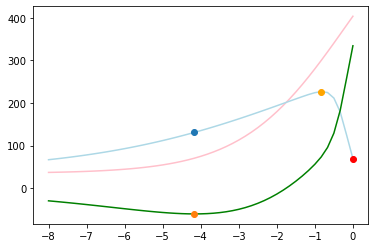

In [25]:
thresh = 15  # threshold for increase in cell size
treatday = df['i_treatday']
ntreatday = len(np.unique(treatday))

ind_in_treatday = indexTools.embeded_index(df,'i_ind','i_treatday')

# find all the equality points (lazy way is extract them off the plots)
import pandas as pd
columns='i_ind treat day rep string i_treatday '+\
        'ncell V_oc_max V_oc_last V_ns_max V_ns_last V_ns_diff '+\
        'min_pos V_min_oc V_min_ns V_min_diff '+\
        'eq_pos V_eq inc_o inc_n'
df_stats = pd.DataFrame(columns=columns.split())
df_stats.set_index('i_ind',inplace=True)
i_inds = df['i_ind'].unique()
fig,ax =plt.subplots(1,1)
for i_ind,itreatday in enumerate(ind_in_treatday):
    ax.clear()
    mask = df['i_ind']==i_ind
    dft=df[mask]

    df_stats.loc[i_ind,'treat':'ncell']=dft.iloc[0]['treat':'pos']
    df_stats.loc[i_ind,'i_treatday':'ncell']=(itreatday,len(dft))
    
 
    bu.posterior_comp_r(ax,df,trace_o,i_ind,code='o',ptype='median',color='pink', )
    x,yo = ax.get_lines()[-1].get_data()
    bu.posterior_comp_r(ax,df,trace_n,i_ind,code='n',ptype='median',color='lightblue')
    x,yn = ax.get_lines()[-1].get_data()
    diffs = yo-yn
    
    ax.plot(x,yo-yn,color='green')
    
    df_stats.loc[i_ind,'V_oc_max']  = max(yo)
    df_stats.loc[i_ind,'V_oc_last'] = yo[0]    
    

    df_stats.loc[i_ind,'V_ns_max']  = max(yn)
    df_stats.loc[i_ind,'V_ns_last'] = yn[0]
    df_stats.loc[i_ind,'V_ns_diff'] = max(yn)-yn[0]

    imax=np.argmax(yn)
    ax.plot(x[0],yn[0],'o',color='red')
    ax.plot(x[imax],yn[imax],'o',color='orange')

    

    xc,yc = get_crossing_metrics(x,yo,yn)
    if( yc is None ): print("cross ",i_ind)
    df_stats.loc[i_ind,'eq_pos']=-xc
    df_stats.loc[i_ind,'V_eq']  =yc    
    
    
    # create the threshold increase for the oocyte
    vmin = np.median(trace_o.get_values('Vmin_o')[:,i_ind])
    ymins = x*0 + vmin*(1+thresh/100.)
    xinc_o,yinc_o = get_crossing_metrics( x, yo,ymins )
    df_stats.loc[i_ind,'inc_o']=-xinc_o
    
    # create the threshold increase for the nurse
    vmin = np.median(trace_n.get_values('Vmin_n')[:,i_ind])
    ymins = x*0 + vmin*(1+thresh/100.)
    xinc_o,yinc_o = get_crossing_metrics( x, yo,ymins )
    df_stats.loc[i_ind,'inc_n']=-xinc_o 
    
    #df_stats.loc[i_ind,'eq_pos']=-x[imin]
    #df_stats.loc[i_ind,'V_eq']  =yn[imin]   

    
    
    # biggest difference between cells
    imin=np.argmin(diffs)
    df_stats.loc[i_ind,'min_pos']   =-x[imin]
    df_stats.loc[i_ind,'V_min_oc']  =yo[imin]
    df_stats.loc[i_ind,'V_min_ns']  =yn[imin]
    df_stats.loc[i_ind,'V_min_diff']=diffs[imin]
   
    plt.plot(x[imin],yn[imin],'o')
    plt.plot( x[imin],yo[imin]-yn[imin],'o')
    
df_stats.to_csv('fitted_model_summary_stats.csv') 
    

In [22]:
df_stats

,treat,day,rep,string,i_treatday,ncell,V_oc_max,V_oc_last,V_ns_max,V_ns_last,V_ns_diff,min_pos,V_min_oc,V_min_ns,V_min_diff,eq_pos,V_eq,inc_o,inc_n
i_ind,,,,,,,,,,,,,,,,,,,
0,cont,0,1,1,0,13,397.707,397.707,208.847,51.5556,157.291,7.38889,87.1517,135.773,-48.6208,3.42108,206.946,14,12.7724
1,cont,0,1,2,0,11,281.838,281.838,222.715,213.99,8.72514,5.0625,73.2644,136.114,-62.8492,1.07407,212.312,9.69686,8.61927
2,cont,0,1,3,0,15,324.44,324.44,205.354,203.018,2.33581,5.8,59.979,122.021,-62.0419,2.00359,177.523,9.03121,8.06216
3,cont,0,2,1,0,16,502.5,502.5,259.943,70.0072,189.936,5.86905,77.0841,144.696,-67.6118,2.87045,226.705,9.53621,8.71731
4,cont,0,2,2,0,14,511.703,511.703,253.38,96.9084,156.471,5.72368,69.2471,133.255,-64.0075,2.89859,207.541,8.68769,7.96021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,banked,10,4,1,4,7,339.204,339.204,207.985,203.638,4.34668,3.33333,57.8751,132.16,-74.285,1.07729,189.297,4.94554,4.44256
70,banked,10,4,2,4,7,450.285,450.285,207.59,70.3695,137.221,3.83333,67.1437,135.643,-68.4995,1.77214,197.581,5.95975,5.41433
71,banked,10,4,3,4,9,452.863,452.863,209.171,95.465,113.706,3.92857,57.7392,135.638,-77.8991,1.69846,193.463,5.4679,4.98747
